<a href="https://colab.research.google.com/github/rohhj622/windPowerPrediction/blob/master/code1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 데이터 불러오기

In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from datetime import datetime
import sys
from keras import models
from keras import layers
from sklearn.preprocessing import MinMaxScaler



## 1) 구글 드라이브 연결

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 2) matlotlib 한글 설정

In [6]:
!apt -qq -y install fonts-nanum
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 

fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


## 3) 데이터 불러오기 시작

In [7]:
allData = pd.read_csv(r'/content/gdrive/My Drive/Colab Notebooks/preprocessing_Data.csv') # 컬럼명 숫자로 들어가게
allData = allData.drop('Unnamed: 0',1)
allData

,datetime,date,time,windForce,tem,windSpeed,windDirect,humidity,vaporPressure,dewPoint,pressure,seaLevelPressure,groundTem
0,2013-01-01 00:00:00,2013-01-01 00:00:00,00:00,0,1.3,3.2,340,77.0,5.2,-2.2,1019.1,1021.3,0.0
1,2013-01-01 01:00:00,2013-01-01 00:00:00,01:00,0,0.9,2.6,320,77.0,5.0,-2.6,1019.0,1021.2,0.0
2,2013-01-01 02:00:00,2013-01-01 00:00:00,02:00,92,1.5,3.0,340,77.0,5.2,-2.1,1019.0,1021.2,0.0
3,2013-01-01 03:00:00,2013-01-01 00:00:00,03:00,269,2.7,1.7,270,74.0,5.5,-1.4,1019.0,1021.2,0.3
4,2013-01-01 04:00:00,2013-01-01 00:00:00,04:00,541,0.6,1.8,320,82.0,5.2,-2.1,1018.5,1020.8,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,2018-12-31 19:00:00,2018-12-31 00:00:00,19:00,8699,4.3,4.7,340,58.0,4.8,-3.2,1032.1,1034.7,3.3
52580,2018-12-31 20:00:00,2018-12-31 00:00:00,20:00,10694,3.9,4.5,360,61.0,4.9,-2.9,1032.0,1034.6,2.9
52581,2018-12-31 21:00:00,2018-12-31 00:00:00,21:00,5494,3.5,4.0,360,59.0,4.6,-3.7,1031.9,1034.5,1.9
52582,2018-12-31 22:00:00,2018-12-31 00:00:00,22:00,2718,3.8,3.4,20,61.0,4.9,-3.0,1031.6,1034.2,2.1


# 2. 데이터 가공하기 

## 1) datetime 컬럼 제작, datetime 형식으로 변환

In [8]:
df = allData.copy()
df['datetime'] = pd.to_datetime(df['datetime'],format='%Y-%m-%d %H:%M', errors='ignore') #합친거 datetime 형식으로 변환
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d', errors='ignore')  #date형식으로 변환
#df['time'] = pd.to_datetime(df['time'],format='%H:%M', errors='ignore') #time 형식으로 변환
df.head(5)

,datetime,date,time,windForce,tem,windSpeed,windDirect,humidity,vaporPressure,dewPoint,pressure,seaLevelPressure,groundTem
0,2013-01-01 00:00:00,2013-01-01,00:00,0,1.3,3.2,340,77.0,5.2,-2.2,1019.1,1021.3,0.0
1,2013-01-01 01:00:00,2013-01-01,01:00,0,0.9,2.6,320,77.0,5.0,-2.6,1019.0,1021.2,0.0
2,2013-01-01 02:00:00,2013-01-01,02:00,92,1.5,3.0,340,77.0,5.2,-2.1,1019.0,1021.2,0.0
3,2013-01-01 03:00:00,2013-01-01,03:00,269,2.7,1.7,270,74.0,5.5,-1.4,1019.0,1021.2,0.3
4,2013-01-01 04:00:00,2013-01-01,04:00,541,0.6,1.8,320,82.0,5.2,-2.1,1018.5,1020.8,0.1


## 2) 년(year), 월(month), 일(day), 계절(season) 컬럼 생성



In [9]:
df['year'] = df['date'].dt.year # 년
df['month'] = df['date'].dt.month # 월
df['day'] = df['date'].dt.day# 일

conditionlist = [
    (df['month'] == 3)|(df['month'] == 4)| (df['month'] == 5) ,
    (df['month'] == 6)|(df['month'] == 7)|(df['month'] == 8) ,
    (df['month'] == 9)|(df['month'] == 10)|(df['month'] == 11),
    (df['month'] == 12)|(df['month'] == 1)|(df['month'] == 2) ]
choicelist = ['0', '1', '2','3']
#choicelist = ['spring', 'summer', 'autumn','winter']
df['season'] = np.select(conditionlist, choicelist, default='Not Specified')
df.head(5)

,datetime,date,time,windForce,tem,windSpeed,windDirect,humidity,vaporPressure,dewPoint,pressure,seaLevelPressure,groundTem,year,month,day,season
0,2013-01-01 00:00:00,2013-01-01,00:00,0,1.3,3.2,340,77.0,5.2,-2.2,1019.1,1021.3,0.0,2013,1,1,3
1,2013-01-01 01:00:00,2013-01-01,01:00,0,0.9,2.6,320,77.0,5.0,-2.6,1019.0,1021.2,0.0,2013,1,1,3
2,2013-01-01 02:00:00,2013-01-01,02:00,92,1.5,3.0,340,77.0,5.2,-2.1,1019.0,1021.2,0.0,2013,1,1,3
3,2013-01-01 03:00:00,2013-01-01,03:00,269,2.7,1.7,270,74.0,5.5,-1.4,1019.0,1021.2,0.3,2013,1,1,3
4,2013-01-01 04:00:00,2013-01-01,04:00,541,0.6,1.8,320,82.0,5.2,-2.1,1018.5,1020.8,0.1,2013,1,1,3


# 3. 데이터 분석 (차트 이용)

## 1) 계절별 발전량 데이터 (겨울 X축 - DateTime)

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


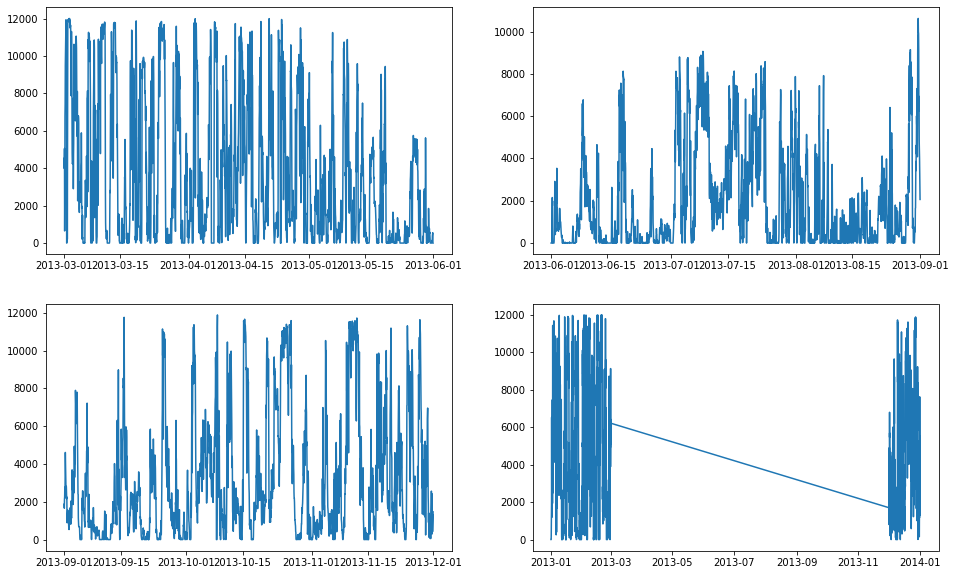

In [10]:
plt.figure(figsize=[16, 10])

pltDf = df.loc[np.logical_and(df['datetime'].dt.year == 2013,np.logical_or(df['month']==3,np.logical_or(df['month']==4,df['month']==5)))]
plt.subplot(221)
plt.plot(pltDf['datetime'],pltDf['windForce'])

pltDf = df.loc[np.logical_and(df['datetime'].dt.year == 2013,np.logical_or(df['month']==6,np.logical_or(df['month']==7,df['month']==8)))]
plt.subplot(222)
plt.plot(pltDf['datetime'],pltDf['windForce'])

pltDf = df.loc[np.logical_and(df['datetime'].dt.year == 2013,np.logical_or(df['month']==9,np.logical_or(df['month']==10,df['month']==11)))]
plt.subplot(223)
plt.plot(pltDf['datetime'],pltDf['windForce'])

pltDf = df.loc[np.logical_and(df['datetime'].dt.year == 2013,np.logical_or(df['month']==12,np.logical_or(df['month']==1,df['month']==2)))]
plt.subplot(224)
plt.plot(pltDf['datetime'],pltDf['windForce'])
plt.show()
plt.close()

## 2) 년도별, 계절별 평균 발전량 


> 년도별, 계절별 평균 발전량 = 겨울 > 봄 > 가을 > 여름





In [11]:
df1 = df.groupby(['year','season'],as_index=False).mean() # 년도별, 계절별 windForce 평균
df1 = df1[['year','season','windForce']] # 컬럼 여기 정의된 3개만 따로 해서 df1에 저장 
df1  =df1.rename(columns={'windForce':'windForceMean'})

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           24 non-null     int64  
 1   season         24 non-null     object 
 2   windForceMean  24 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 768.0+ bytes


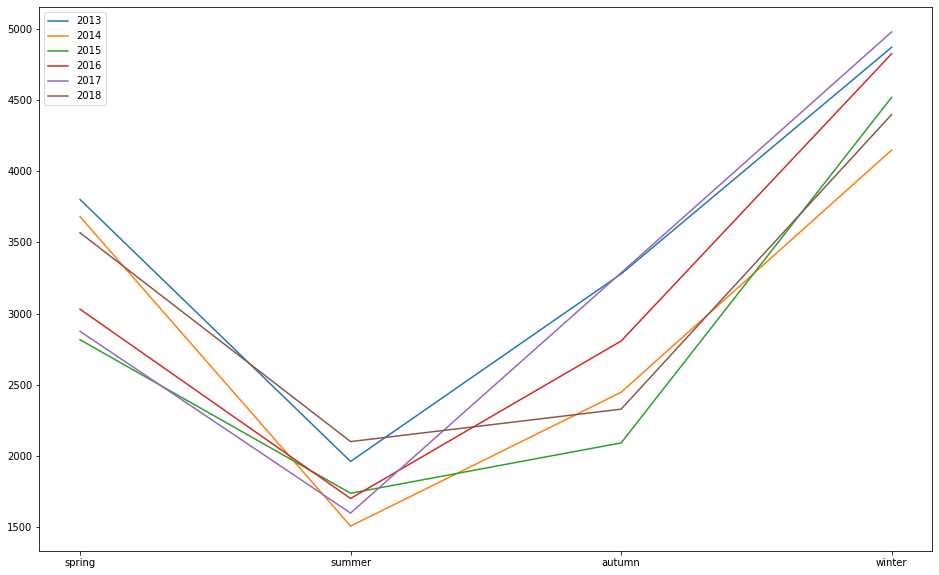

In [12]:
plt.figure(figsize=[16, 10])

a = 2013
val = ['spring','summer','autumn','winter']
for i in range(0,6): # 7까지 - 2019, 6까지 - 2018
  k = df1.loc[df1['year'] == a]
  plt.plot(k['season'],k['windForceMean'],label=a) 
  plt.xticks(k['season'], val) # x값 0,1,2,3 -> spring,summer,autumn,winter
  
  a = a + 1

plt.legend()
plt.show()
plt.close()

## 3) 년도별, 시간별 평균 발전량

> 년도별, 시간별 평균 발전량 = 13시 가장 발전량 많음





In [13]:
df1 = df.groupby(['year','time'],as_index=False).mean() # 년도별, 계절별 windForce 평균
df1 = df1[['year','time','windForce',]] # 컬럼 여기 정의된 3개만 따로 해서 df1에 저장 
df1  =df1.rename(columns={'windForce':'windForceMean'})

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           144 non-null    int64  
 1   time           144 non-null    object 
 2   windForceMean  144 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.5+ KB


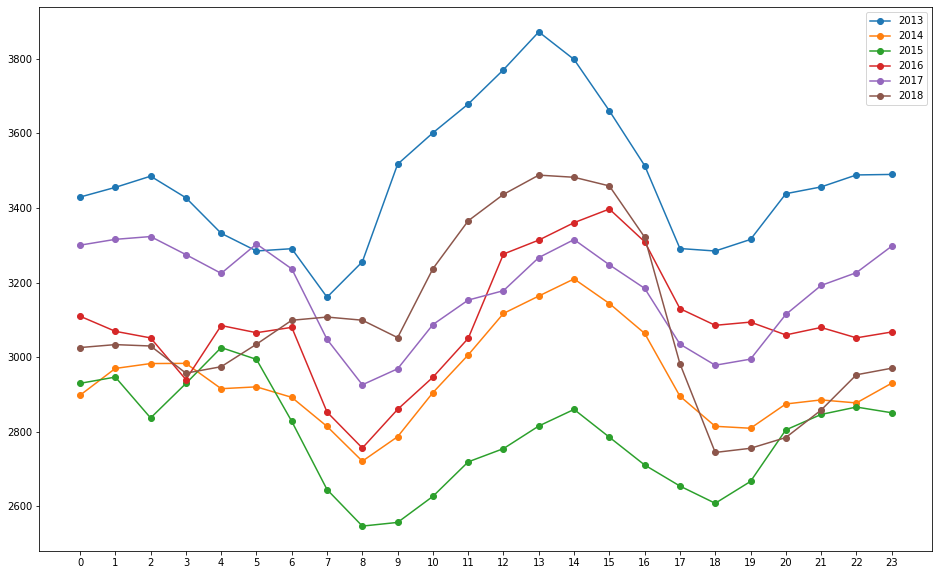

In [14]:
plt.figure(figsize=[16, 10])

a = 2013
val = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23']

for i in range(0,6): # 7까지 - 2019, 6까지 - 2018
  k = df1.copy()[df1['year'] == a] #복사해서 쓰기,,ㅎㅎ,,,copy()  안 그러면 warning 뜸
  k['time'] = pd.to_datetime(k['time'],format='%H:%M', errors='ignore') 
  k = k.sort_values(["time"], ascending=[True])
  plt.xticks(k['time'],val)
  plt.plot(k['time'],k['windForceMean'],label=a,marker="o")
  
  a = a + 1

plt.legend()
plt.show()
plt.close()

In [15]:
df .describe()

,windForce,tem,windSpeed,windDirect,humidity,vaporPressure,dewPoint,pressure,seaLevelPressure,groundTem,year,month,day
count,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000
mean,3091.753556,15.901982,3.111604,221.538110,74.397214,15.457181,11.029155,1013.898403,1016.049857,17.037534,2015.500228,6.523962,15.726609
std,3342.329416,8.134264,1.718996,110.268796,15.777120,8.802159,9.510797,7.686442,7.748968,10.383129,1.707485,3.448452,8.798896
min,0.000000,-6.400000,0.000000,0.000000,13.000000,2.000000,-14.200000,962.500000,964.400000,-4.200000,2013.000000,1.000000,1.000000
25%,374.000000,9.100000,1.800000,140.000000,63.000000,7.400000,2.700000,1007.900000,1010.000000,8.800000,2014.000000,4.000000,8.000000
50%,1764.500000,16.600000,2.900000,270.000000,76.000000,14.000000,12.000000,1014.000000,1016.200000,17.200000,2016.000000,7.000000,16.000000
75%,4968.000000,22.500000,4.100000,290.000000,88.000000,22.100000,19.100000,1019.900000,1022.100000,24.000000,2017.000000,10.000000,23.000000
max,12005.000000,34.100000,17.700000,360.000000,100.000000,38.000000,28.100000,1034.800000,1037.000000,64.500000,2018.000000,12.000000,31.000000


## 4) 년도별, 월별 평균 발전량





In [16]:
df1 = df.groupby(['year','month'],as_index=False).mean() # 년도별, 계절별 windForce 평균
df1 = df1[['year','month','windForce',]] # 컬럼 여기 정의된 3개만 따로 해서 df1에 저장 
df1  =df1.rename(columns={'windForce':'windForceMean'})

df1.head()

,year,month,windForceMean
0,2013,1,4853.974462
1,2013,2,5271.589286
2,2013,3,4941.778226
3,2013,4,4438.387500
4,2013,5,2042.930108


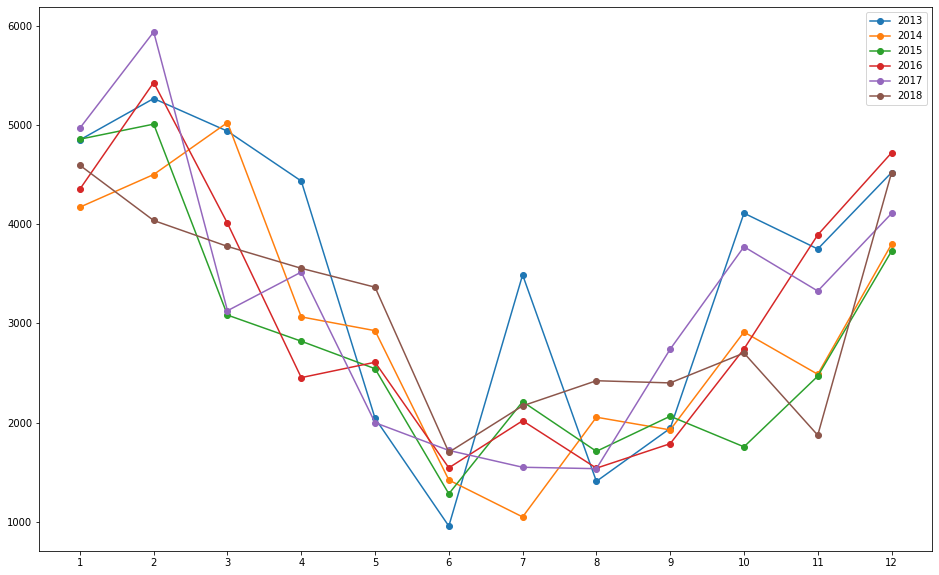

In [17]:
plt.figure(figsize=[16, 10])

a = 2013
val = ['1','2','3','4','5','6','7','8','9','10','11','12']

for i in range(0,6): # 7까지 - 2019, 6까지 - 2018
  k = df1.copy()[df1['year'] == a] #복사해서 쓰기,,ㅎㅎ,,,copy()  안 그러면 warning 뜸
  plt.xticks(k['month'],val)
  plt.plot(k['month'],k['windForceMean'],label=a, marker="o")
  
  a = a + 1

plt.legend()
plt.show()
plt.close()

## 5) 년도별 평균 발전량

In [18]:
df1 = df.groupby(['year'],as_index=False).mean() # 년도별, 계절별 windForce 평균
df1 = df1[['year','windForce','windSpeed']] # 컬럼 여기 정의된 3개만 따로 해서 df1에 저장 

df1  =df1.rename(columns={'windForce':'windForceMean'})
df1  =df1.rename(columns={'windSpeed':'windSpeedMean'})

df1.head()

,year,windForceMean,windSpeedMean
0,2013,3470.586073,3.344269
1,2014,2940.790868,3.144589
2,2015,2783.717808,2.937888
3,2016,3087.088342,2.975000
4,2017,3174.612100,3.105548


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54413 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47141 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48156 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/bac

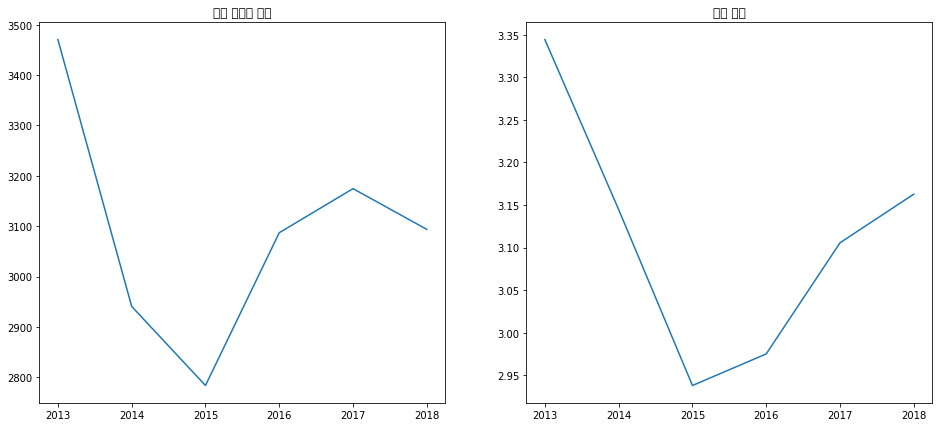

In [19]:
k = df1.copy()

plt.figure(figsize=[16, 7])

plt.subplot(121)
ax = plt.plot(k['year'],k['windForceMean'])
plt.gca().set_title('풍력 발전량 평균')
plt.subplot(122)
ax1 = plt.plot(k['year'],k['windSpeedMean'])
plt.gca().set_title('풍속 평균')

plt.show()
plt.close()

# 4. 훈련 & 예측

## 1) train-test data 나누기

In [20]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from keras import models, layers

In [21]:
df2 = df.copy()
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          52584 non-null  datetime64[ns]
 1   date              52584 non-null  datetime64[ns]
 2   time              52584 non-null  object        
 3   windForce         52584 non-null  int64         
 4   tem               52584 non-null  float64       
 5   windSpeed         52584 non-null  float64       
 6   windDirect        52584 non-null  int64         
 7   humidity          52584 non-null  float64       
 8   vaporPressure     52584 non-null  float64       
 9   dewPoint          52584 non-null  float64       
 10  pressure          52584 non-null  float64       
 11  seaLevelPressure  52584 non-null  float64       
 12  groundTem         52584 non-null  float64       
 13  year              52584 non-null  int64         
 14  month             5258

In [22]:
X = df2[['tem','windSpeed','windDirect','humidity','groundTem','seaLevelPressure']]
y = df2[['windForce']]

transform = MinMaxScaler()
trans_X=transform.fit_transform(X)
trans_y=transform.fit_transform(y)

X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=10)
print('train data 개수 : ', len(X_train))
print('test data 개수: ', len(X_test))
print(len(X_train)+len(X_test))

train data 개수 :  36808
test data 개수:  15776
52584


## 2) LinearRegression() // 단순회귀분석

In [23]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [24]:
lr.fit(X_train,y_train)

r_square = lr.score(X_test,y_test)
print(r_square)

0.45322931117355525


In [25]:
y_hat = lr.predict(X)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


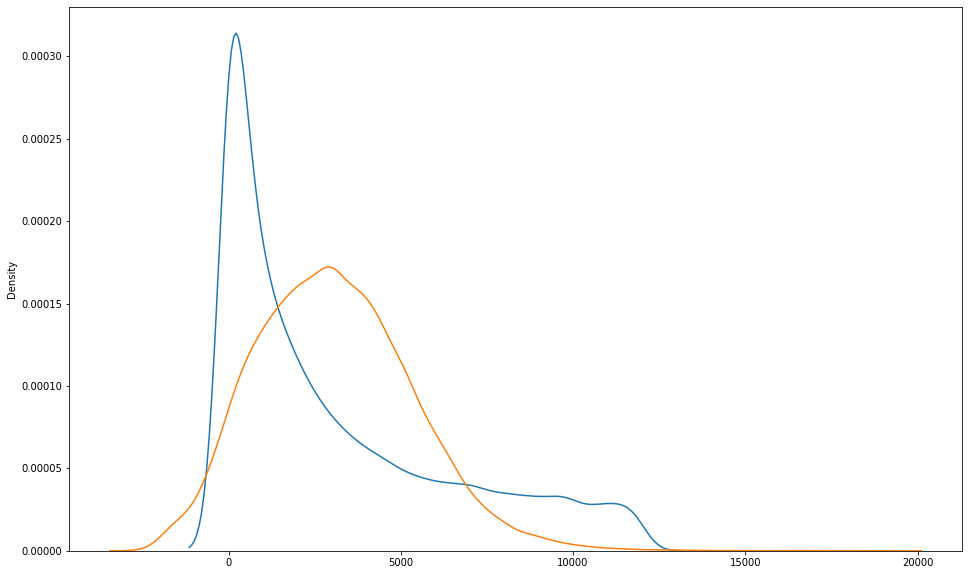

In [26]:
plt.figure(figsize=(16,10))
ax1 = sns.distplot(y, hist=False, label='y')
ax2 = sns.distplot(y_hat, hist=False, label='y_hat',ax = ax1)
plt.show()
plt.close()

## 3) PolynomioalFeatures() // 다항회귀분석

In [27]:
from sklearn.preprocessing import PolynomialFeatures

In [28]:
poly  = PolynomialFeatures(degree=2) #2차항 적용
X_train_poly = poly.fit_transform(X_train) #X_train 데이터를 2차항으로 변형

print('원 데이터 : ',X_train.shape)
print('2차항 변환 데이터 : ',X_train_poly.shape)

원 데이터 :  (36808, 5)
2차항 변환 데이터 :  (36808, 21)


In [29]:
pr = LinearRegression()
pr.fit(X_train_poly,y_train)

X_test_poly = poly.fit_transform(X_test)

r_square = pr.score(X_test_poly,y_test)
print(r_square)
# 단순회귀분석보다 r_square 값이 조금 증가하였다.

0.4919341944959904


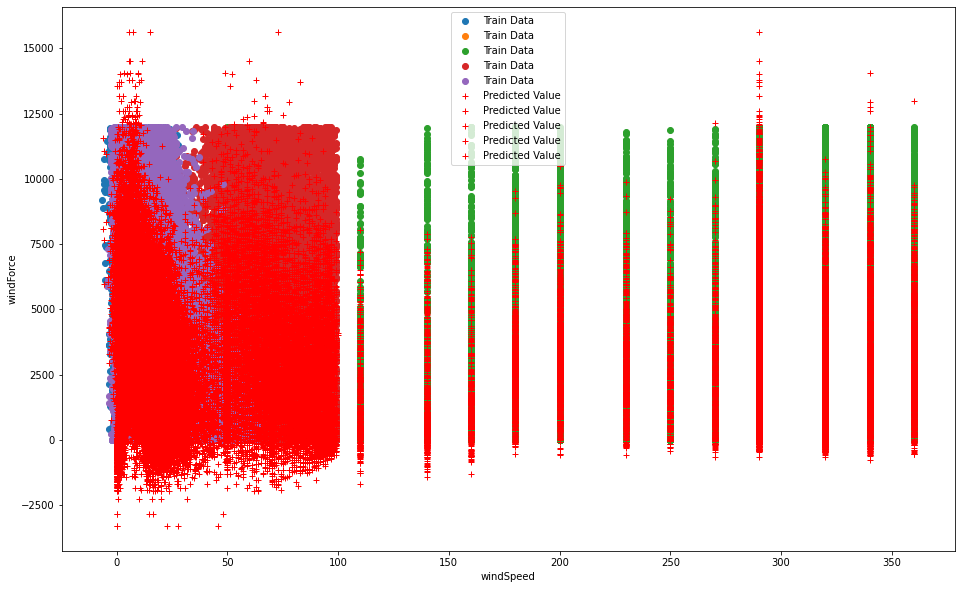

In [30]:
y_hat_test = pr.predict(X_test_poly)

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(1,1,1)
ax.plot(X_train,y_train,'o',label='Train Data')
ax.plot(X_test,y_hat_test,'r+',label='Predicted Value')
ax.legend(loc='best')
plt.xlabel('windSpeed')
plt.ylabel('windForce')

plt.show()
plt.close()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


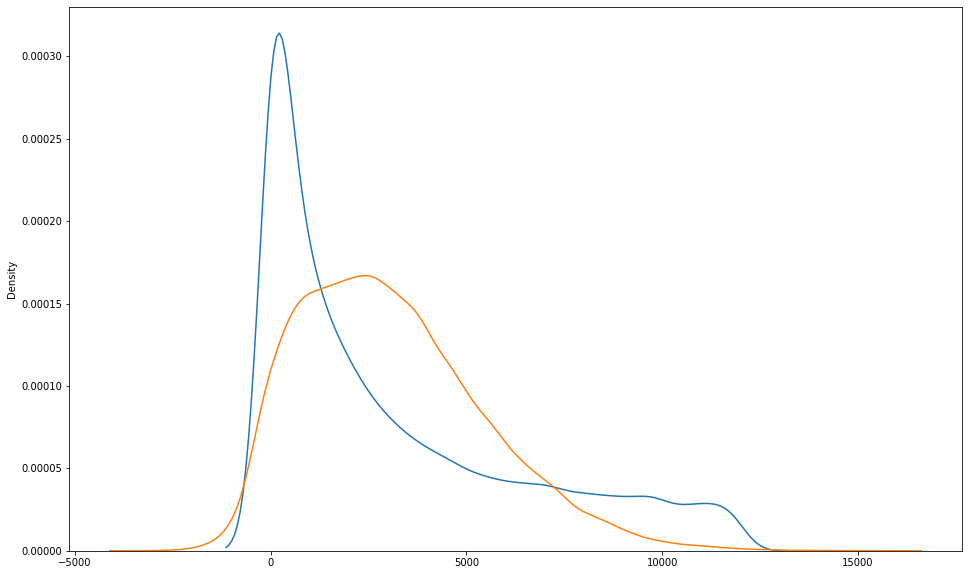

In [31]:
X_poly = poly.fit_transform(X)
y_hat = pr.predict(X_poly)
plt.figure(figsize=(16,10))
ax1 = sns.distplot(y,hist=False,label='y')
ax2 = sns.distplot(y_hat,hist=False,label='y_hat',ax=ax1)

plt.show()
plt.close()

## 4) ARIMA 모델

In [32]:
df3 = df.copy()
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          52584 non-null  datetime64[ns]
 1   date              52584 non-null  datetime64[ns]
 2   time              52584 non-null  object        
 3   windForce         52584 non-null  int64         
 4   tem               52584 non-null  float64       
 5   windSpeed         52584 non-null  float64       
 6   windDirect        52584 non-null  int64         
 7   humidity          52584 non-null  float64       
 8   vaporPressure     52584 non-null  float64       
 9   dewPoint          52584 non-null  float64       
 10  pressure          52584 non-null  float64       
 11  seaLevelPressure  52584 non-null  float64       
 12  groundTem         52584 non-null  float64       
 13  year              52584 non-null  int64         
 14  month             5258

In [33]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          52584 non-null  datetime64[ns]
 1   date              52584 non-null  datetime64[ns]
 2   time              52584 non-null  object        
 3   windForce         52584 non-null  int64         
 4   tem               52584 non-null  float64       
 5   windSpeed         52584 non-null  float64       
 6   windDirect        52584 non-null  int64         
 7   humidity          52584 non-null  float64       
 8   vaporPressure     52584 non-null  float64       
 9   dewPoint          52584 non-null  float64       
 10  pressure          52584 non-null  float64       
 11  seaLevelPressure  52584 non-null  float64       
 12  groundTem         52584 non-null  float64       
 13  year              52584 non-null  int64         
 14  month             5258

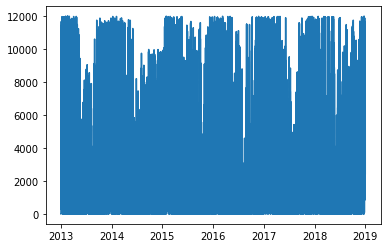

In [34]:
plt.plot(df3['datetime'],df3['windForce'])
plt.show()
plt.close()

## 5. test


In [35]:
df4 = df.copy()
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          52584 non-null  datetime64[ns]
 1   date              52584 non-null  datetime64[ns]
 2   time              52584 non-null  object        
 3   windForce         52584 non-null  int64         
 4   tem               52584 non-null  float64       
 5   windSpeed         52584 non-null  float64       
 6   windDirect        52584 non-null  int64         
 7   humidity          52584 non-null  float64       
 8   vaporPressure     52584 non-null  float64       
 9   dewPoint          52584 non-null  float64       
 10  pressure          52584 non-null  float64       
 11  seaLevelPressure  52584 non-null  float64       
 12  groundTem         52584 non-null  float64       
 13  year              52584 non-null  int64         
 14  month             5258

In [36]:
# X = df2[['windSpeed']]
# y = df2[['windForce']]
# X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=10)
# print('train data 개수 : ', len(X_train))
# print('test data 개수: ', len(X_test))

# print(len(X_train)+len(X_test))

In [37]:
lr  = LinearRegression(fit_intercept=True, normalize=True, copy_X=True)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [38]:
print("score : ", format(lr.score(X_train,y_train)))

score :  0.46250251730102654


In [39]:
y_predict = lr.predict(X_test)

In [40]:
print(format(lr.score(X_test,y_test)))

0.4532293111735551


In [41]:
tr = MinMaxScaler()

X = df2[['windSpeed','seaLevelPressure']]
y = df2[['windForce']]

X = tr.fit_transform(X)



In [42]:
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=10)
print('train data 개수 : ', len(X_train))
print('test data 개수: ', len(X_test))

print(len(X_train)+len(X_test))

train data 개수 :  36808
test data 개수:  15776
52584


In [43]:
network = models.Sequential()

In [44]:
network.add(layers.Dense(128,activation='relu'))
network.add(layers.Dense(64,activation='relu'))
network.add(layers.Dense(1))

In [ ]:
network.compile(optimizer='rmsprop',loss='mean_squared_error')
network.fit(X_train, y_train, epochs=200, batch_size=128)

In [46]:
# def compare_graph(network,X_test, y_test):
#   y_pred = network.predict(X_test).flatten()
#   real = []
#   pred = []
#   index = []
#   for i in range(100):
#     index.append(i)
#     real.append(y_test[i])
#     pred.append(y_pred[i])
#   plt.figure(figsize =(10,5))
#   plt.plot(index,real,'b-',label='Real')
#   plt.plot(index,pred,'r--',label='Pred')
#   plt.legend(loc='center left', fontsize=12)
#   plt.show()

In [47]:
y_pred = network.predict(X_test).flatten()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


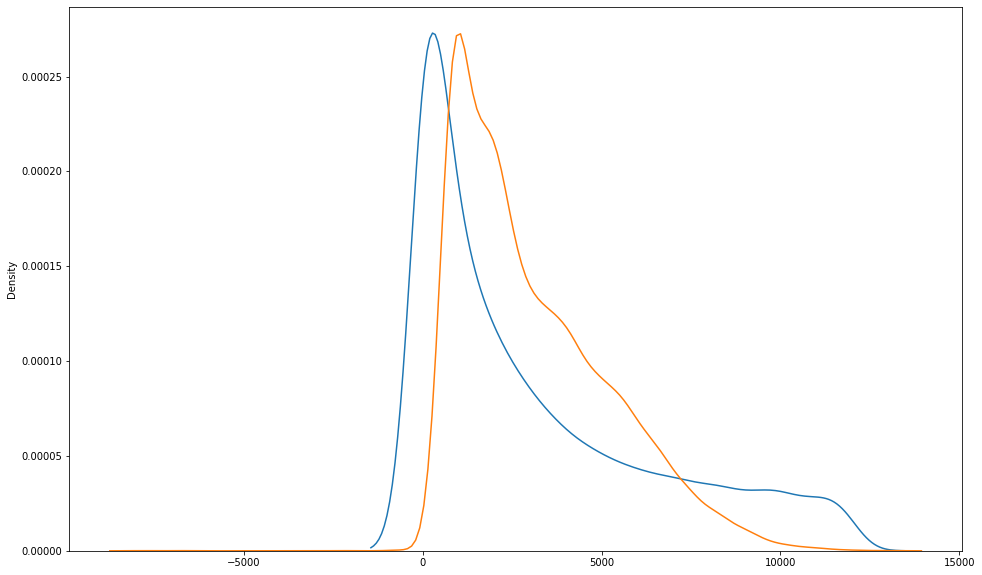

In [48]:
plt.figure(figsize=(16,10))
ax1 = sns.distplot(y_test,hist=False,label='y')
ax2 = sns.distplot(y_pred,hist=False,label='y_hat',ax=ax1)

plt.show()
plt.close()

In [75]:
# X = df2[['tem','windSpeed','humidity','groundTem','windDirect','seaLevelPressure']] #,'windDirect'
# X = df2[['tem','windSpeed','groundTem']] #,'windDirect'
X = df2[['tem','windSpeed']] #,'windDirect'
y = df2[['windForce']]

transform = MinMaxScaler()
trans_X=transform.fit_transform(X)
trans_y=transform.fit_transform(y)

#X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=10)
X_train, X_test,y_train, y_test = train_test_split(trans_X,trans_y,test_size=0.2,random_state=10)
print('train data 개수 : ', len(X_train))
print('test data 개수: ', len(X_test))
print(len(X_train)+len(X_test))

train data 개수 :  42067
test data 개수:  10517
52584


In [69]:
X_train

array([[0.55555556, 0.24293785, 0.2503639 ],
       [0.62716049, 0.17514124, 0.31295488],
       [0.51358025, 0.28248588, 0.43813683],
       ...,
       [0.68641975, 0.3559322 , 0.47307132],
       [0.77530864, 0.05084746, 0.42066958],
       [0.21728395, 0.21468927, 0.09024745]])

In [76]:
network = models.Sequential()
# network.add(layers.Dense(512, input_dim=6, activation='relu'))
# network.add(layers.Dense(512, input_dim=3, activation='relu'))
network.add(layers.Dense(512, input_dim=2, activation='relu'))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dense(128, activation='relu'))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dense(32, activation='relu'))
network.add(layers.Dense(1, activation='sigmoid'))

In [77]:
network.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['acc'])
network.fit(X_train, y_train, epochs=43 , batch_size=32)

scores = network.evaluate(X_test, y_test, batch_size=32)
print("%s: %.2f%%" %(network.metrics_names[1], scores[1]*100))

Epoch 1/43
1315/1315 [==============================] - 5s 3ms/step - loss: 0.4840 - acc: 0.1178
Epoch 2/43
1315/1315 [==============================] - 5s 3ms/step - loss: 0.4730 - acc: 0.1146
Epoch 3/43
1315/1315 [==============================] - 5s 3ms/step - loss: 0.4732 - acc: 0.1165
Epoch 4/43
1315/1315 [==============================] - 5s 4ms/step - loss: 0.4691 - acc: 0.1190
Epoch 5/43
1315/1315 [==============================] - 4s 3ms/step - loss: 0.4708 - acc: 0.1167
Epoch 6/43
1315/1315 [==============================] - 5s 3ms/step - loss: 0.4719 - acc: 0.1164
Epoch 7/43
1315/1315 [==============================] - 4s 3ms/step - loss: 0.4718 - acc: 0.1156
Epoch 8/43
1315/1315 [==============================] - 4s 3ms/step - loss: 0.4723 - acc: 0.1165
Epoch 9/43
1315/1315 [==============================] - 4s 3ms/step - loss: 0.4677 - acc: 0.1181
Epoch 10/43
1315/1315 [==============================] - 5s 3ms/step - loss: 0.4712 - acc: 0.1159
Epoch 11/43
1315/1315 [======

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


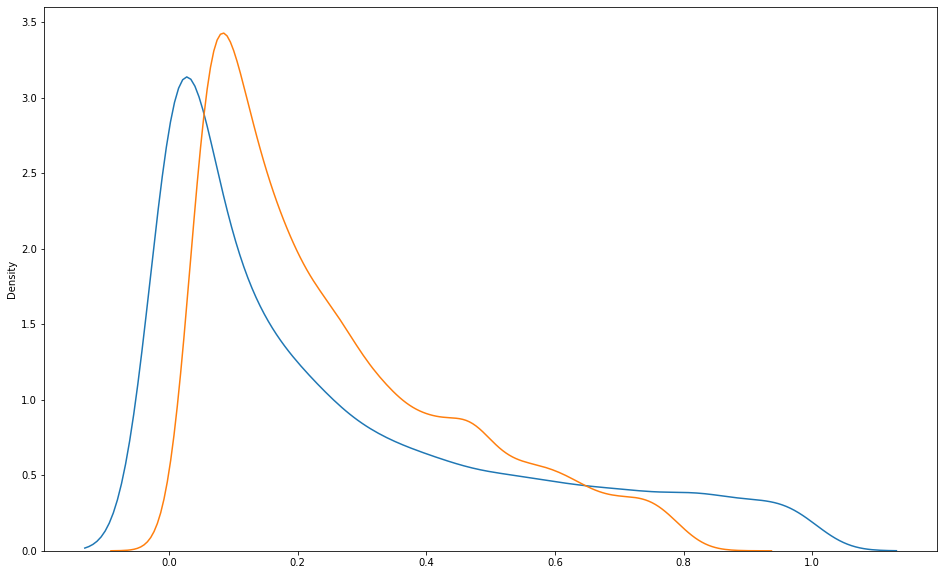

In [74]:
y_pred = network.predict(X_test).flatten()

plt.figure(figsize=(16,10))
ax1 = sns.distplot(y_test,hist=False,label='y')
ax2 = sns.distplot(y_pred,hist=False,label='y_hat',ax=ax1)

plt.show()
plt.close()